In this repo, we will apply target encoding technique, is instead a method of encoding categories as numbers, like one-hot or label encoding, with difference  that it also uses the target to create the encoding. This makes it what we call a supervised feature engineering technique.

#### Target Encoding
is any kind of encoding that replaces a features's categories with some number derived from the target.

* A simple and effective version is to apply a group aggregation from Lesson 3, like the mean

In [1]:
#Using exmple of Automobiles dataset, compute the average price of each vehicle's make
import pandas as pd
autos = pd.read_csv('./data/autos.csv')

autos['make_encoded'] = autos.groupby('make')['price'].transform('mean')

autos[['make', 'price', 'make_encoded']].head(10)

,make,price,make_encoded
0,alfa-romero,13495,15498.333333
1,alfa-romero,16500,15498.333333
2,alfa-romero,16500,15498.333333
3,audi,13950,17859.166667
4,audi,17450,17859.166667
5,audi,15250,17859.166667
6,audi,17710,17859.166667
7,audi,18920,17859.166667
8,audi,23875,17859.166667
9,bmw,16430,26118.750000


This technique sometimes called a mean encoding. Applied to a binary target, it's also called bin counting, likelihood encoding, impact encoding, and leave one out encoding

#### Smoothing
An encoding like this presents a couple of problems, however. 

- First are unknown categories. Target encodings create a special risk of overfitting, which means they need to be trained on an independent 'encoding' split. When we join  the encoding to future splits, Pandas will fill in missing values for any categories not present in the encoding split. These missing values we would have to impute somehow.

- Second are rare categories. When a category only occurs a few times in the dataset, any statisics calculated on its group are unlikely to be very accurate. In the Automobiles dataset, the mercurcy make only occurs once. The 'mean' price we calculated is just the price of that one vehicle, which might not be very representative of any Mercuries we might see in the future. Target encoding rare categories can make overfitting more likely.

A solution to these problems is to add smoothing. The idea is to blend the in_category average with the overall average. Rare categories get less weight on their category average, while missing categories just get the overall average.

In pseudocode:
encoding = weight * in_category + (1- weight) * overall

Where weight is a value between 0 and 1 calculated from the category frequency

An easy way to determine the value for weight is to compute an m-estimate:
weight = n / (n+m)

where n is the total number of times that category occurs in the data. The parameter m determines the 'smoothing factor'. Larger values of m put more weight on the overall estimate.

<img src="https://i.imgur.com/1uVtQEz.png">

In the Automobiles dataset there are three cars with the make chevrolet. If we chose m=2.0, then the chevrolet category would be encoded with 60% of the average Chevrolet price plus 40$ of the overall average price

chevrolet = 0.6 * 6000.00 + 0.4 * 13285.03

When choosing a value for m, consider how noisy we expect the categories to be. Does the price of a vehicle vary a greate deal within each make? Would we need a lot of data to get good estimates? If so, it could be better to choose a larger value for m, If the average price for each make were relatively stable, a smaller value could be okay.

#### Use Cases for Target Encoding
Great for:
* High-cardinality features: A feature with a large number of categories can be troublesome to encode: a one-hot encoding would generate too many features and alternatives, like a label encoding, might not be appropriate for that feature. A target encoding derives numbes for the categories using the feature's most important property: its relationship with the target.
* Domain-motivated features: From prior experience, you might suspect that a categorical feature should be important even if it scored poorly with a feature metric. A target encoding can help reaveal a feature's true informativeness.

#### Example - MovieLens1M
The dataset contains one-million movie ratings by users of the Movielens website, with features describing each user and movie

In [2]:
#import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

plt.style.use('seaborn-v0_8-whitegrid')
plt.rc('figure', autolayout=True)
plt.rc("axes",
      labelweight='bold',
      labelsize='large',
      titleweight='bold',
      titlesize=14,
      titlepad=10,)

warnings.filterwarnings('ignore')

df = pd.read_csv('./data/movielens1m.csv')
df = df.astype(np.uint8, errors='ignore') #reduce memory footprint
print('Number of Unique Zipcodes: {}'.format(df['Zipcode'].nunique()))

Number of Unique Zipcodes: 3439


With over 3000 categories, the Zipcode feature makes a good candidate for target encoding, and the size of this dataset - over one-million rows, means we can spare some data to create the encoding.

we will start by creating 25% split to train the target encoder

In [7]:
X = df.copy()
y = X.pop('Rating')

X_encode = X.sample(frac=0.25)
y_encode = y[X_encode.index]
X_pretrain = X.drop(X_encode.index)
y_train = y[X_pretrain.index]

In [8]:
#use category_encoders, m-estimate econder, in scikit-learn-contrib
from category_encoders import MEstimateEncoder

#create the encoder instance, choose m to control noise
encoder = MEstimateEncoder(cols=['Zipcode'], m=5.0)

#Fit the encoder on the encoding split
encoder.fit(X_encode, y_encode)

#Encode the Zipcode column to create the final training data
X_train = encoder.transform(X_pretrain)

Compare the encoded values to the target to see how informative our encoding might be

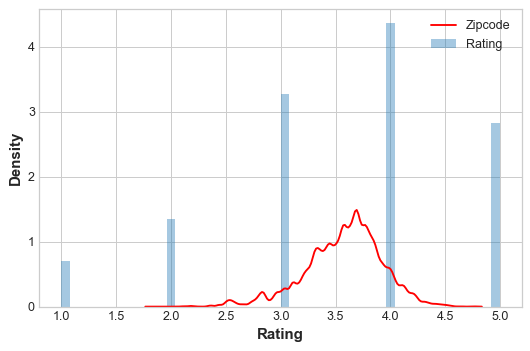

In [10]:
plt.figure(dpi=90)
ax = sns.distplot(y, kde=False, norm_hist=True)
ax = sns.kdeplot(X_train.Zipcode, color='r', ax=ax)
ax.set_xlabel('Rating')
ax.legend(labels=['Zipcode', 'Rating']);

The distribution of the encoded Zipcode freature roughly follows the distrubution of the actual ratings, meaning that movie-watchers differed enough in their ratings from zipcode that our target encoding was able to capture useful information